In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from skimage.feature import local_binary_pattern
import pywt

In [1]:
train_folder = 'D:/Sougata/Jochen_Triesch_ASL/train'
img_width, img_height = 64, 64
batch_size = 64
test_size = 0.10
num_classes = 10

# Load Data
all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label': folder, 'path': os.path.join(label_folder, f)}
                 for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

c:\Users\Sougata\anaconda3\envs\rphand\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Sougata\anaconda3\envs\rphand\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
c:\Users\Sougata\anaconda3\envs\rphand\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


      label                                            path
0         a     D:/Sougata/Jochen_Triesch_ASL/train\a\0.jpg
1         a     D:/Sougata/Jochen_Triesch_ASL/train\a\1.jpg
2         a     D:/Sougata/Jochen_Triesch_ASL/train\a\2.jpg
3         a     D:/Sougata/Jochen_Triesch_ASL/train\a\3.jpg
4         a     D:/Sougata/Jochen_Triesch_ASL/train\a\4.jpg
...     ...                                             ...
29995     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2995.jpg
29996     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2996.jpg
29997     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2997.jpg
29998     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2998.jpg
29999     y  D:/Sougata/Jochen_Triesch_ASL/train\y\2999.jpg

[30000 rows x 2 columns]


In [2]:
x_train, x_holdout = train_test_split(data_df, test_size=test_size, random_state=42, stratify=data_df[['label']])
x_train, x_test = train_test_split(x_train, test_size=0.20, random_state=42, stratify=x_train[['label']])

train_datagen = ImageDataGenerator(
    rescale=1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1/255.0)
holdout_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train, x_col='path', y_col='label',
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size, shuffle=True
)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col='path', y_col='label',
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size, shuffle=True
)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col='path', y_col='label',
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size, shuffle=False
)

Found 21000 validated image filenames belonging to 10 classes.
Found 6000 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames belonging to 10 classes.


In [ ]:

LPQ_RADIUS = 1
LPQ_POINTS = 8 * LPQ_RADIUS
LPQ_METHOD = 'uniform'

def haar_wavelet_transform(img):
    coeffs2 = pywt.dwt2(img, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return LL, LH, HL, HH

def compute_lpq(img, radius=LPQ_RADIUS, points=LPQ_POINTS, method=LPQ_METHOD):
    lbp = local_binary_pattern(img, points, radius, method)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist / hist.sum()
    return hist

def extract_features(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    LL, LH, HL, HH = haar_wavelet_transform(img)
    ll_hist = compute_lpq(LL)
    lh_hist = compute_lpq(LH)
    hl_hist = compute_lpq(HL)
    hh_hist = compute_lpq(HH)
    feature_vector = np.concatenate([ll_hist, lh_hist, hl_hist, hh_hist])
    return feature_vector

feature_vectors = []
for _, row in data_df.iterrows():
    img_path = row['path']
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    features = extract_features(img)
    feature_vectors.append(features)

feature_vectors = np.array(feature_vectors)

class DualPathSqueezeAttention(layers.Layer):
    def __init__(self, channels):
        super(DualPathSqueezeAttention, self).__init__()
        self.channels = channels
        self.local_fc1 = layers.Dense(channels // 2, activation='relu')
        self.local_fc2 = layers.Dense(channels, activation='sigmoid')
        self.global_fc1 = layers.Dense(channels // 2, activation='relu')
        self.global_fc2 = layers.Dense(channels, activation='sigmoid')

    def call(self, x):
        local_out = layers.Conv2D(self.channels, kernel_size=(3, 3), padding='same')(x)
        local_out = layers.GlobalAveragePooling2D()(local_out)
        local_out = self.local_fc1(local_out)
        local_out = self.local_fc2(local_out)
        local_out = tf.reshape(local_out, [-1, 1, 1, self.channels])
        local_out = x * local_out

        global_out = layers.GlobalAveragePooling2D()(x)
        global_out = self.global_fc1(global_out)
        global_out = self.global_fc2(global_out)
        global_out = tf.reshape(global_out, [-1, 1, 1, self.channels])
        global_out = x * global_out

        fused_out = local_out + global_out
        entropy_mask = self._entropy_mask(fused_out)
        return fused_out * entropy_mask

    def _entropy_mask(self, x):
        entropy = -tf.reduce_sum(x * tf.math.log(x + 1e-10), axis=[1, 2]) / np.log(x.shape[1] * x.shape[2])
        entropy_mask = tf.reshape(entropy, [-1, 1, 1, self.channels])
        return entropy_mask

def build_enhanced_alexnet(input_shape=(img_width, img_height, 1), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    x = layers.Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)

    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = DualPathSqueezeAttention(channels=384)(x)

    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Compile Model
model = build_enhanced_alexnet()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size=batch_size,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30
938/938 [==============================] - 180s 0ms/step - loss: 2.8720 - accuracy: 0.2349 - val_loss: 2.5518 - val_accuracy: 0.3268
Epoch 2/30
938/938 [==============================] - 185s 0ms/step - loss: 2.7165 - accuracy: 0.2974 - val_loss: 2.3277 - val_accuracy: 0.4303
Epoch 3/30
938/938 [==============================] - 175s 0ms/step - loss: 2.5381 - accuracy: 0.3588 - val_loss: 2.1723 - val_accuracy: 0.5159
Epoch 4/30
938/938 [==============================] - 190s 0ms/step - loss: 2.4146 - accuracy: 0.4622 - val_loss: 2.1037 - val_accuracy: 0.5312
Epoch 5/30
938/938 [==============================] - 198s 0ms/step - loss: 2.2500 - accuracy: 0.5376 - val_loss: 1.9253 - val_accuracy: 0.5989
Epoch 6/30
938/938 [==============================] - 188s 0ms/step - loss: 2.0808 - accuracy: 0.6104 - val_loss: 1.8567 - val_accuracy: 0.6359
Epoch 7/30
938/938 [==============================] - 193s 0ms/step - loss: 1.9024 - accuracy: 0.6513 - val_loss: 1.8018 - val_accuracy:

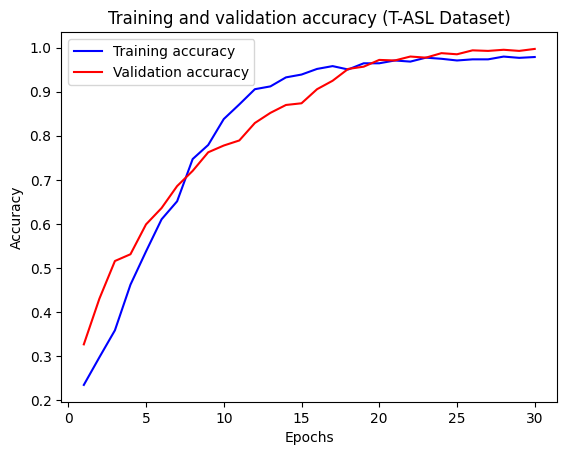

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],'b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy (T-ASL Dataset)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


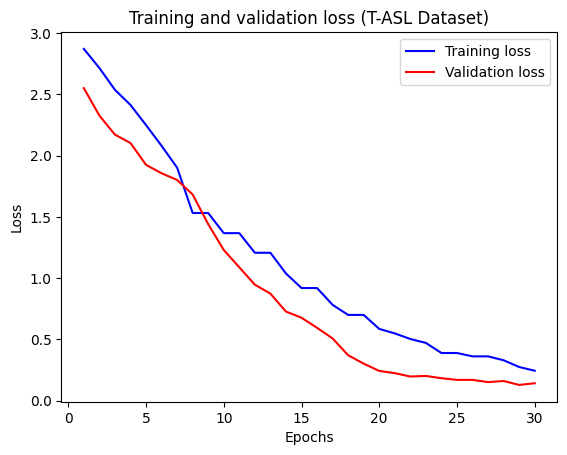

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b', label='Training Loss')
plt.plot(history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and validation loss (T-ASL Dataset)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
